In [41]:
!pip install pyspark
!pip install tensorflowonspark

In [42]:
# Import necessary libraries
from pyspark.sql import SparkSession
from pyspark.context import SparkContext
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np
import tensorflowonspark as tfos
from tensorflowonspark import TFCluster
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorSlicer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.context import SparkContext
from pyspark.sql.functions import count, when, isnull
import tensorflow as tf
import tensorflowonspark as tfos
import pyspark.sql.functions as F
from pyspark.sql.functions import col
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [43]:
# Create SparkSession
spark = SparkSession.builder \
    .appName("MalwareDetection") \
    .getOrCreate()

# Access SparkContext from SparkSession
sc = spark.sparkContext

In [44]:
# Load the dataset into a Spark DataFrame
dataset_path = "Android Malware Detection.csv"
df = spark.read.csv(dataset_path, header=True, inferSchema=True)

In [45]:
# Display the schema of the DataFrame
df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- ACCESS_ALL_DOWNLOADS: double (nullable = true)
 |-- ACCESS_CACHE_FILESYSTEM: double (nullable = true)
 |-- ACCESS_CHECKIN_PROPERTIES: double (nullable = true)
 |-- ACCESS_COARSE_LOCATION: double (nullable = true)
 |-- ACCESS_FINE_LOCATION: double (nullable = true)
 |-- ACCESS_LOCATION_EXTRA_COMMANDS: double (nullable = true)
 |-- ACCESS_MOCK_LOCATION: double (nullable = true)
 |-- ACCESS_NETWORK_STATE: double (nullable = true)
 |-- ACCESS_SURFACE_FLINGER: double (nullable = true)
 |-- ACCESS_WIFI_STATE: double (nullable = true)
 |-- ACCOUNT_MANAGER: double (nullable = true)
 |-- AUTHENTICATE_ACCOUNTS: double (nullable = true)
 |-- BATTERY_STATS: double (nullable = true)
 |-- BIND_ACCESSIBILITY_SERVICE: double (nullable = true)
 |-- BIND_APPWIDGET: double (nullable = true)
 |-- BIND_CARRIER_MESSAGING_SERVICE: double (nullable = true)
 |-- BIND_DEVICE_ADMIN: double (nullable = true)
 |-- BIND_DREAM_SERVICE: double (nullable = true)
 |-- BIND_

In [46]:
#display first 20 rows
df.show()

+---+--------------------+-----------------------+-------------------------+----------------------+--------------------+------------------------------+--------------------+--------------------+----------------------+-----------------+---------------+---------------------+-------------+--------------------------+--------------+------------------------------+-----------------+------------------+---------------------------------+-----------------+----------------------------------------+------------------+----------------+-----------------+-------------+----------------------+----------------+--------------+---------+---------------+--------------------+------------+-----+-------------------------+-------------+----------------+------------------+----------+---------------+------+--------------------+---------------------------+--------------------+------------------------------+--------------------+--------------------+---------------------------+-----------------+---------------+-------

In [47]:
# Count the number of rows in the dataset
row_count = df.count()
print("Number of rows in the dataset:", row_count)

Number of rows in the dataset: 4863


In [48]:
# Summary statistics
print("Summary Statistics:")
df.describe().show()

Summary Statistics:
+-------+------------------+--------------------+-----------------------+-------------------------+----------------------+--------------------+------------------------------+--------------------+--------------------+----------------------+------------------+-------------------+---------------------+-------------------+--------------------------+-------------------+------------------------------+--------------------+--------------------+---------------------------------+--------------------+----------------------------------------+--------------------+--------------------+--------------------+--------------------+----------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------------+-------------------------+--------------------+-------------------+--------------------+-------------------+--------------------+-------------------+--------------------+---------------------

In [49]:
# checking the shape of the dataframe
num_rows = df.count() # Counting the number of rows.
num_columns =len(df.columns) # Length of columns.
print(f"Shape: ({num_rows}, {num_columns})") # Prints the shape of the dataset.

Shape: (4863, 150)


In [50]:
# checking for missing data
missing_data = df.agg(*[count(when(isnull(c), c)).alias(c) for c in df.columns])
missing_data.show()

+---+--------------------+-----------------------+-------------------------+----------------------+--------------------+------------------------------+--------------------+--------------------+----------------------+-----------------+---------------+---------------------+-------------+--------------------------+--------------+------------------------------+-----------------+------------------+---------------------------------+-----------------+----------------------------------------+------------------+----------------+-----------------+-------------+----------------------+----------------+--------------+---------+---------------+--------------------+------------+-----+-------------------------+-------------+----------------+------------------+----------+---------------+------+--------------------+---------------------------+--------------------+------------------------------+--------------------+--------------------+---------------------------+-----------------+---------------+-------

In [51]:
# Handling missing values
df_cleaned = df.na.drop()
# Show the cleaned DataFrame
df_cleaned.show()

+---+--------------------+-----------------------+-------------------------+----------------------+--------------------+------------------------------+--------------------+--------------------+----------------------+-----------------+---------------+---------------------+-------------+--------------------------+--------------+------------------------------+-----------------+------------------+---------------------------------+-----------------+----------------------------------------+------------------+----------------+-----------------+-------------+----------------------+----------------+--------------+---------+---------------+--------------------+------------+-----+-------------------------+-------------+----------------+------------------+----------+---------------+------+--------------------+---------------------------+--------------------+------------------------------+--------------------+--------------------+---------------------------+-----------------+---------------+-------

In [52]:
# drop unnecessary columns
df = df_cleaned.drop('_c0')

In [53]:
# display new df
df.show()

+--------------------+-----------------------+-------------------------+----------------------+--------------------+------------------------------+--------------------+--------------------+----------------------+-----------------+---------------+---------------------+-------------+--------------------------+--------------+------------------------------+-----------------+------------------+---------------------------------+-----------------+----------------------------------------+------------------+----------------+-----------------+-------------+----------------------+----------------+--------------+---------+---------------+--------------------+------------+-----+-------------------------+-------------+----------------+------------------+----------+---------------+------+--------------------+---------------------------+--------------------+------------------------------+--------------------+--------------------+---------------------------+-----------------+---------------+-----------

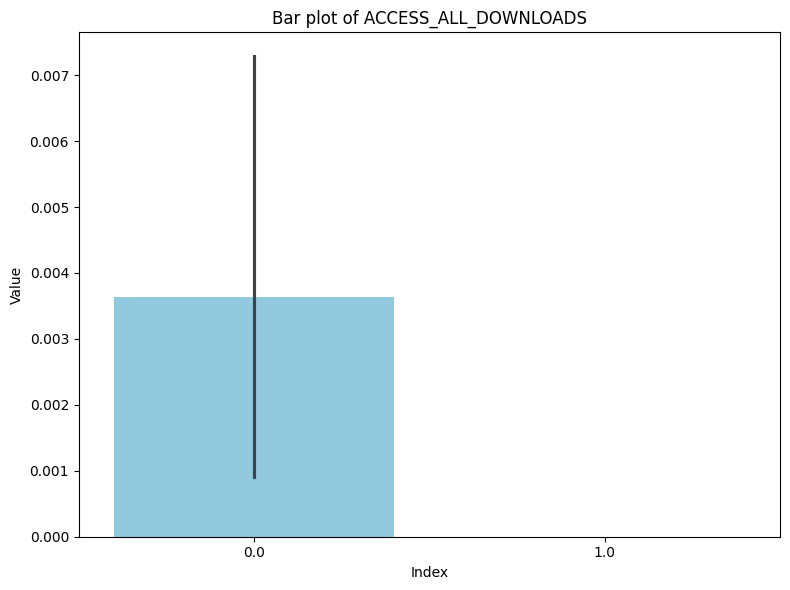

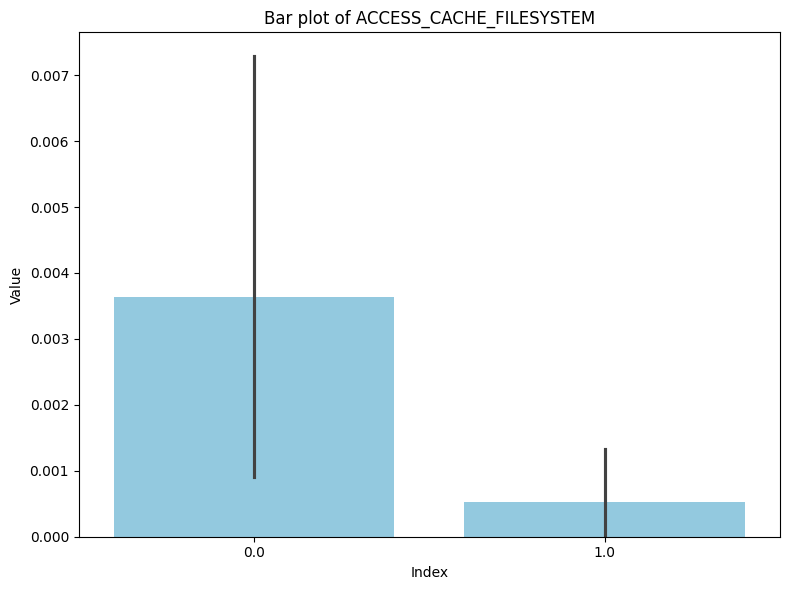

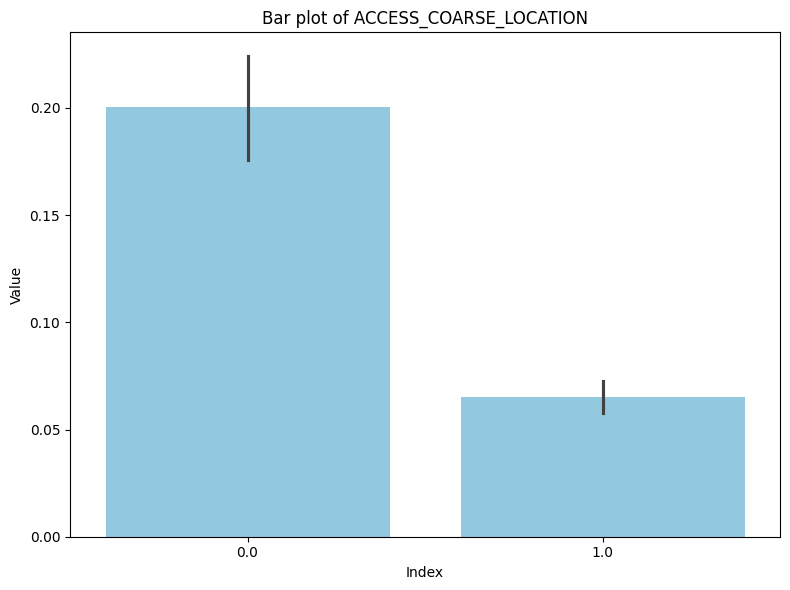

In [54]:
# Plot bar plots for selected features
selected_features = ["ACCESS_ALL_DOWNLOADS", "ACCESS_CACHE_FILESYSTEM", "ACCESS_COARSE_LOCATION"]
for feature in selected_features:
    plt.figure(figsize=(8, 6))
    sns.barplot(x=df.select('Label').rdd.flatMap(lambda x: x).collect(), y=df.select(feature).rdd.flatMap(lambda x: x).collect(), color='skyblue')
    plt.title(f'Bar plot of {feature}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.tight_layout()
    plt.show()

Feature Correlations:


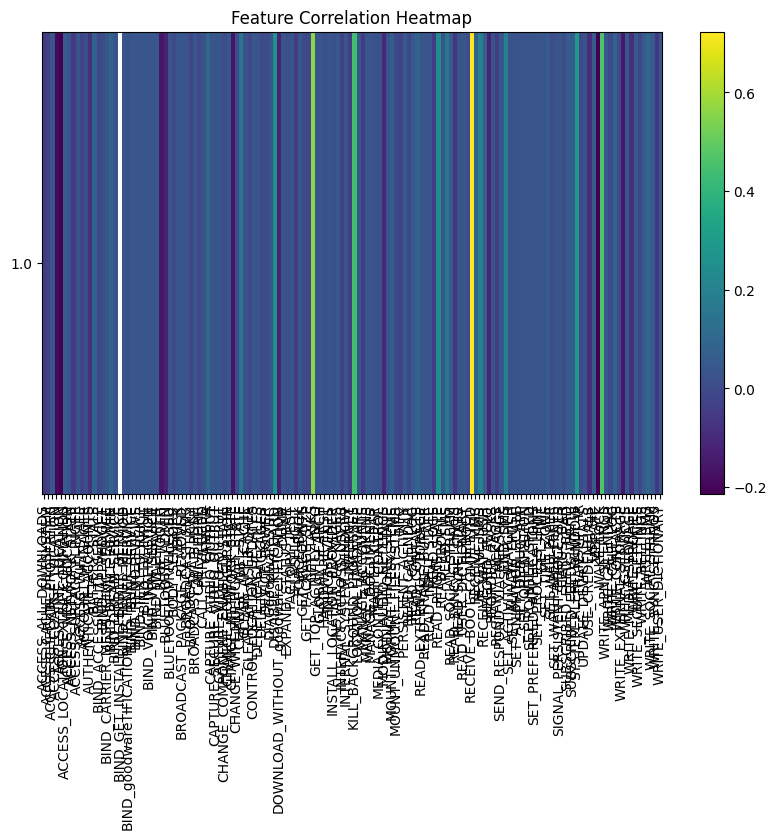

In [55]:
# Feature correlations
print("Feature Correlations:")
correlation_matrix = df.select([F.corr(col, 'Label').alias(col) for col in df.columns]).toPandas().set_index('Label')
plt.figure(figsize=(10, 6))
plt.imshow(correlation_matrix, cmap='viridis', interpolation='nearest', aspect='auto')
plt.colorbar()
plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation='vertical')
plt.yticks(range(len(correlation_matrix.index)), correlation_matrix.index)
plt.title('Feature Correlation Heatmap')
plt.show()

In [56]:
# Check the class distribution
class_distribution = df.groupBy("Label").count().orderBy("Label")
class_distribution.show()

+-----+-----+
|Label|count|
+-----+-----+
|  0.0| 1098|
|  1.0| 3764|
+-----+-----+



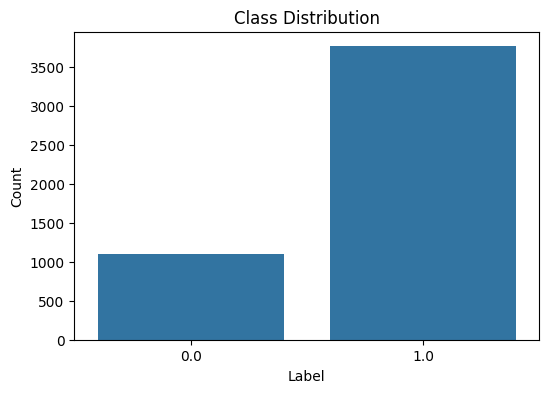

In [57]:
# Visualize the class distribution
class_distribution_pd = class_distribution.toPandas()
plt.figure(figsize=(6, 4))
sns.barplot(x="Label", y="count", data=class_distribution_pd)
plt.title("Class Distribution")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

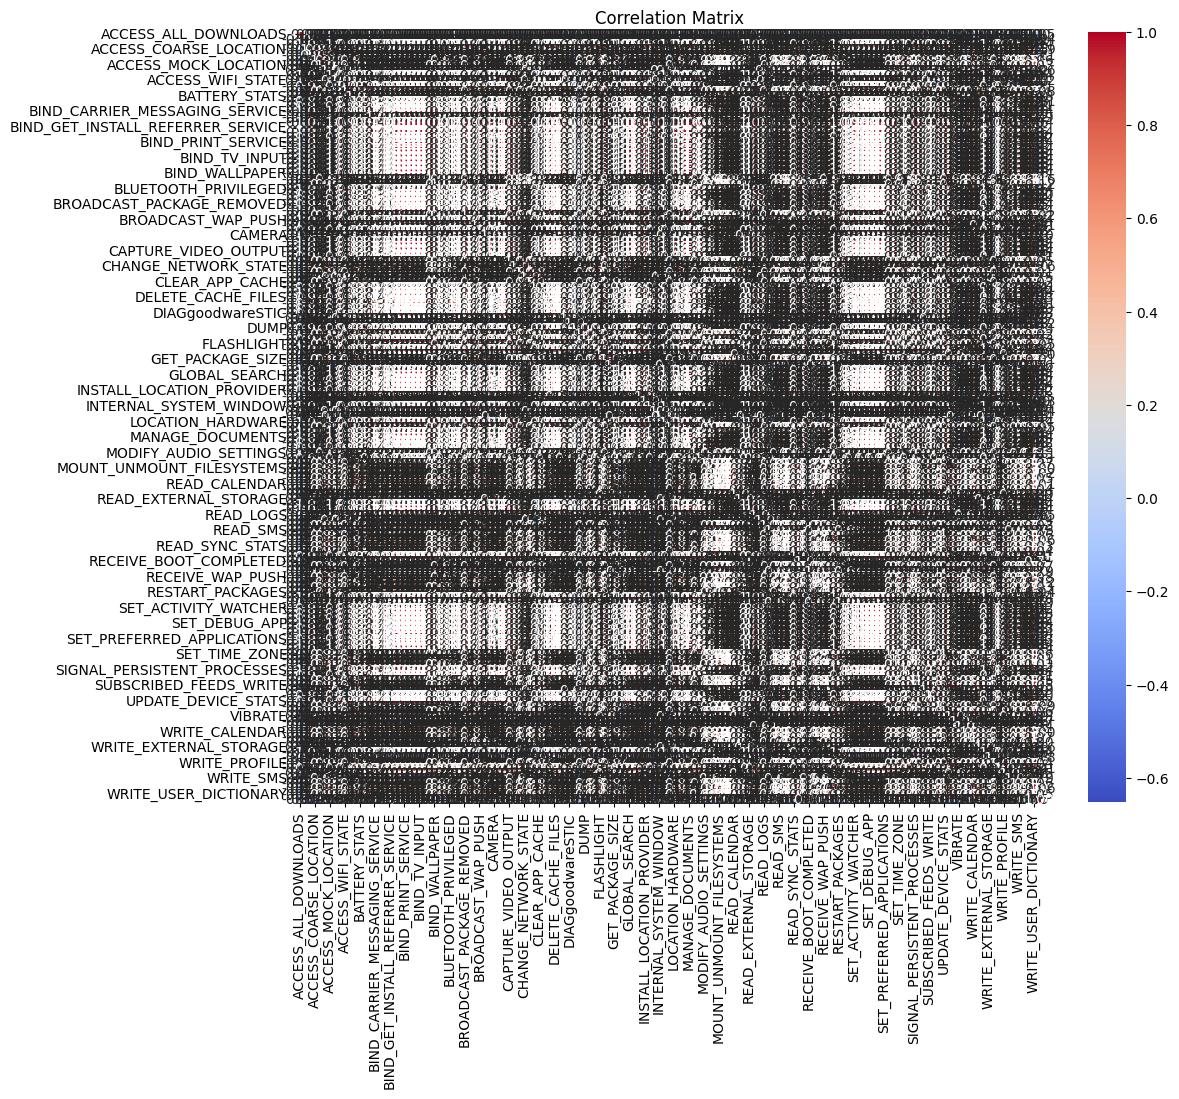

In [58]:
# Correlation Analysis
correlation_matrix = df.drop("_c0").toPandas().corr()
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [59]:
# Assemble features
feature_cols = df.columns[1:-1]  # Exclude _c0 and Label columns
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
data_assembled = assembler.transform(df)

In [60]:
# Train a RandomForestClassifier
rf = RandomForestClassifier(labelCol="Label", featuresCol="features", numTrees=100)
model = rf.fit(data_assembled)

In [61]:
# Get feature importances
feature_importances = model.featureImportances.toArray()

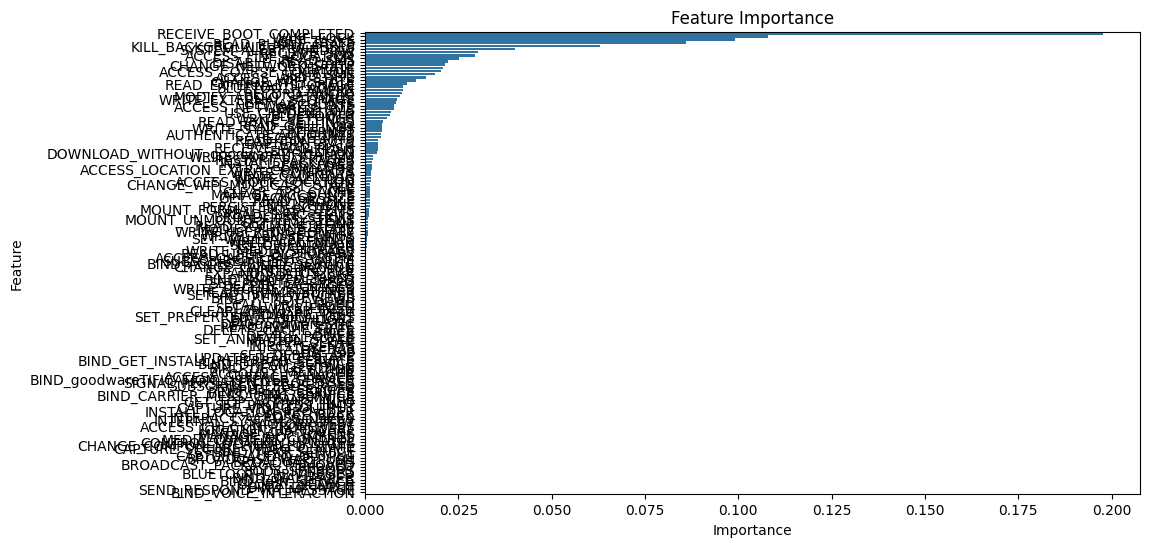

In [62]:
# Visualize feature importances
feature_importance_pd = pd.DataFrame({"Feature": feature_cols, "Importance": feature_importances})
feature_importance_pd_sorted = feature_importance_pd.sort_values(by="Importance", ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x="Importance", y="Feature", data=feature_importance_pd_sorted)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

In [63]:
# Get the indices of the top 20 features based on their importances
top_20_indices = feature_importances.argsort()[-20:][::-1]

# Select only the top 20 features from the feature vector
slicer = VectorSlicer(inputCol="features", outputCol="selected_features", indices=top_20_indices)
data_selected = slicer.transform(data_assembled)

# Train the RandomForestClassifier model using only the top 20 features
rf_selected = RandomForestClassifier(labelCol="Label", featuresCol="selected_features", numTrees=100)
model_selected = rf_selected.fit(data_selected)

In [64]:
# Split the data into training and testing sets
train_data_selected, test_data_selected = data_selected.randomSplit([0.8, 0.2], seed=42)

In [65]:
# Evaluate the model's performance on the testing set
evaluator = BinaryClassificationEvaluator(labelCol="Label")
test_predictions = model_selected.transform(test_data_selected)
auc = evaluator.evaluate(test_predictions)
print("AUC on the testing set:", auc)

# Calculate accuracy
accuracy = test_predictions.filter("prediction == Label").count() / test_predictions.count()
print("Accuracy on the testing set:", accuracy)

# Calculate precision
precision = test_predictions.filter("prediction == 1 AND Label == 1").count() / test_predictions.filter("prediction == 1").count()
print("Precision on the testing set:", precision)

# Calculate recall
recall = test_predictions.filter("prediction == 1 AND Label == 1").count() / test_predictions.filter("Label == 1").count()
print("Recall on the testing set:", recall)

AUC on the testing set: 0.990015054621255
Accuracy on the testing set: 0.9731471535982814
Precision on the testing set: 0.99002849002849
Recall on the testing set: 0.9747545582047685


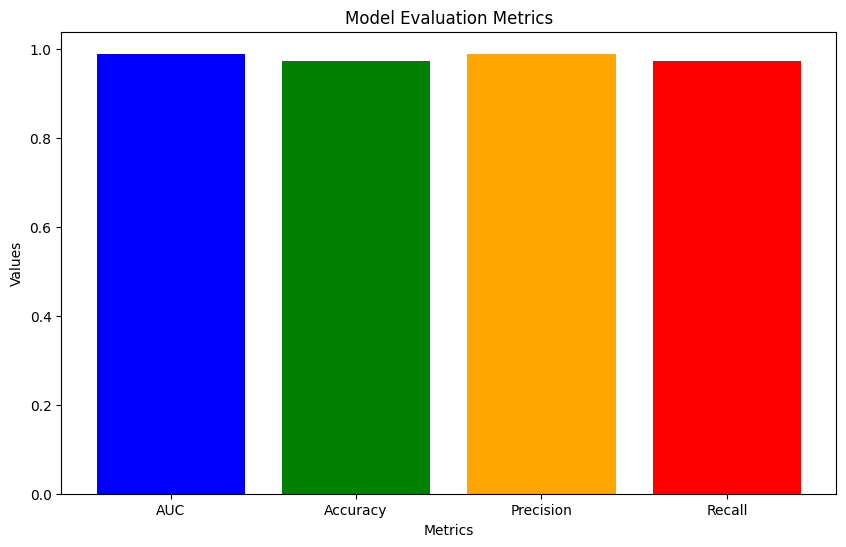

In [66]:
# Define evaluation metrics
metrics = ['AUC', 'Accuracy', 'Precision', 'Recall']
values = [auc, accuracy, precision, recall]

# Plot bar graph
plt.figure(figsize=(10, 6))
plt.bar(metrics, values, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Model Evaluation Metrics')
plt.show()

In [67]:
# Stop the SparkSession
spark.stop()